# Notebook 06: Whole Wood Ljungdahl Metabolism

This notebook is part of the research paper titled:

Optimizing acetogenic CO(2) utilization through metabolic and process engineering highlights the potential of thermophilic bioproduction

This notebook uses a stoichiometric constraint-based model of the Wood-Ljungdahl pathway and its products to determine the energy generated as ATP while producing various compounds. The model was built using the genome-scale metabolic model of Clostridium ljungdahlii as a template. Notably, bifurcating enzymes restoring the energy and redox co-factors are this time included, only ATP can be produced or consumed, which is included in the model as a sink reaction, along with ADP and Pi (notebook S06).

Notebook author: Philip J. Gorter de Vries

In [1]:
import numpy as np
import pandas as pd
import cobra.io
import escher
import matplotlib.pyplot as plt
from escher import Builder
from cobra import Model, Reaction, Metabolite

In [2]:
WLmodel = cobra.io.read_sbml_model('../Models/WLPathway_bifurcating.xml')

Using license file /Users/phivri/gurobi.lic
Academic license - for non-commercial use only - expires 2022-07-23


To properly compare all results for the different substrate and product combinations, the model is constrained by the flux through CODH_ACS, so to equal Acetyl-CoA.

In [3]:
WLmodel.reactions.CODH_ACS.bounds = 1,1

Define carboxydotrophic and homoacetogenic media, Acetyl-CoA is constrained, so substrates are only absent or present and uptake rates are unconstrained

In [4]:
medium_carb = WLmodel.medium
medium_carb['EX_co_e'] = 1000
medium_carb['EX_co2_e'] = 0
medium_carb['EX_h2_e'] = 0

medium_hom = WLmodel.medium
medium_hom['EX_co_e'] = 0
medium_hom['EX_co2_e'] = 1000
medium_hom['EX_h2_e'] = 1000

In [5]:
objectives = pd.Series(["EX_ac_e","EX_etoh_e","EX_act_e","EX_but_e","EX_btoh_e","EX_btd_RR_e"])
names = pd.Series(["Acetate","Ethanol","Acetone","Butyrate","Butanol","Butanediol"], index=objectives)
formulas = pd.Series(["CH3COOH","C2H5OH","C3H6O","C4H7O2","C4H9OH","C4H10O2"], index=objectives)
Cmol =  pd.Series([2,2,3,4,4,4], index=objectives)

Yields = pd.DataFrame(index=objectives)
Yields["ATPcarb"] = Yields["ATPhom"] = Yields["YPScarb"] = Yields["YPShom"] = "NaN"

for x in objectives:
    print(WLmodel.reactions.get_by_id(x).name)
    WLmodel.objective = x
    with WLmodel:
        WLmodel.medium = medium_carb
        WLmodel.optimize()
        Yields.ATPcarb[x] = -WLmodel.reactions.SK_atp_c.flux/WLmodel.reactions.EX_co_e.flux
        Yields.YPScarb[x] = -WLmodel.slim_optimize()*Cmol[x]/WLmodel.reactions.EX_co_e.flux
        print(f" carb: {round(WLmodel.reactions.EX_co_e.flux,2)} CO + {round(WLmodel.reactions.EX_h2o_e.flux,2)} H2O + {round(WLmodel.reactions.EX_co2_e.flux,2)} CO2 + {round(WLmodel.slim_optimize(),2)} {formulas[x]} + {round(WLmodel.reactions.EX_h_e.flux,2)} H+ + {round(WLmodel.reactions.SK_atp_c.flux,2)} ATP")
        print("   ATP/Electron donor: ", round(Yields.ATPcarb[x],2))
        print("   Product/Electron donor: ", round(Yields.YPScarb[x],2))

    with WLmodel:
        WLmodel.medium = medium_hom
        WLmodel.optimize()
        Yields.ATPhom[x] = -WLmodel.reactions.SK_atp_c.flux/WLmodel.reactions.EX_h2_e.flux
        Yields.YPShom[x] = -WLmodel.slim_optimize()*Cmol[x]/WLmodel.reactions.EX_h2_e.flux
        print("   ATP/Electron donor: ", round(Yields.ATPhom[x],2))
        print("   Product/Electron donor: ", round(Yields.YPShom[x],2), "\n")
        
Yields.index = names

Acetate exchange
 carb: -4.0 CO + -0.33 H2O + 2.0 CO2 + 1.0 CH3COOH + -0.67 H+ + 1.67 ATP
   ATP/Electron donor:  0.42
   Product/Electron donor:  0.5
   ATP/Electron donor:  0.08
   Product/Electron donor:  0.5 

Ethanol exchange
 carb: -6.0 CO + -0.67 H2O + 4.0 CO2 + 1.0 C2H5OH + -2.33 H+ + 2.33 ATP
   ATP/Electron donor:  0.39
   Product/Electron donor:  0.33
   ATP/Electron donor:  0.06
   Product/Electron donor:  0.33 

Acetone exchange
 carb: -4.0 CO + -0.5 H2O + 2.5 CO2 + 0.5 C3H6O + -1.0 H+ + 1.0 ATP
   ATP/Electron donor:  0.25
   Product/Electron donor:  0.38
   ATP/Electron donor:  -0.08
   Product/Electron donor:  0.38 

Butyrate (n-C4:0) exchange
 carb: -5.0 CO + -0.17 H2O + 3.0 CO2 + 0.5 C4H7O2 + -1.33 H+ + 1.83 ATP
   ATP/Electron donor:  0.37
   Product/Electron donor:  0.4
   ATP/Electron donor:  0.03
   Product/Electron donor:  0.4 

Butanol exchange
 carb: -6.0 CO + -0.5 H2O + 4.0 CO2 + 0.5 C4H9OH + -2.0 H+ + 2.0 ATP
   ATP/Electron donor:  0.33
   Product/Electron d

### Calculate maximal thermodynamic ATP yield

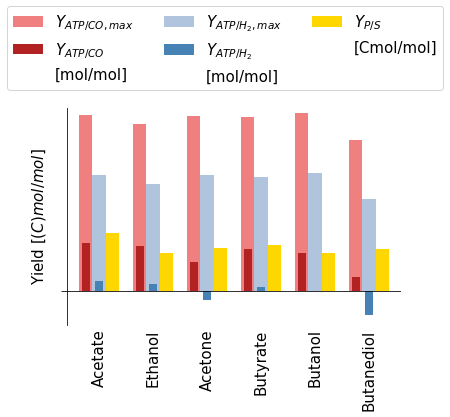

In [98]:
# Load the thermodynamic data of the compounds
dfGR = pd.read_csv("../Data/EnthalpyGibbs.csv", index_col="Compound")["dfGR"]
dfHR = pd.read_csv("../Data/EnthalpyGibbs.csv", index_col="Compound")["dfHR"]

ElemFormulae = pd.DataFrame({
    "Acetate": [2,4,2],
    "Acetone": [3,6,1],
    "Ethanol": [2,6,1],
    "Butanol": [4,10,1],
    "Butyrate": [4,8,2],
    "Butanediol": [4,10,2]},
    index=pd.Index(["C","H","O"])).T

ElemFormulae["form"] = "C" + ElemFormulae["C"].astype(str) + "H" + ElemFormulae["H"].astype(str) + "O" + ElemFormulae["O"].astype(str)

S_carb = pd.DataFrame()
S_carb["CO"] = -ElemFormulae["C"] + ElemFormulae["O"] - ElemFormulae["C"] - ElemFormulae["H"]/2
S_carb["Water"] = -ElemFormulae["H"]/2
S_carb["CO2"] = -ElemFormulae["O"] + ElemFormulae["C"] + ElemFormulae["H"]/2
S_carb = S_carb.astype(int)

S_hom = pd.DataFrame()
S_hom["H2"] = -ElemFormulae["H"]/2 + ElemFormulae["O"] - 2*ElemFormulae["C"]
S_hom["CO2"] = -ElemFormulae["C"]
S_hom["Water"] = -ElemFormulae["O"] + 2*ElemFormulae["C"] 
S_hom = S_hom.astype(int)

dG_hom = (pd.DataFrame.sum(S_hom*dfGR,axis = 1, skipna = True) + dfGR[S_hom.index])/S_hom["H2"]
ATP_hom = dG_hom/37.64
ATP_hom = ATP_hom[names]

dG_carb = (pd.DataFrame.sum(S_carb*dfGR,axis = 1, skipna = True) + dfGR[S_carb.index])/S_carb["CO"]
ATP_carb = dG_carb/37.64
ATP_carb = ATP_carb[names]

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False

X = ATP_carb.index
X_axis = np.arange(len(X))

plt.axis([-0.6, len(X)-0.4,-0.3, 1.6])
plt.bar(X_axis - 0.25, ATP_carb, 0.25, color = "lightcoral", label = '$Y_{ATP/CO,max}$')#' [mol/mol]')
plt.bar(X_axis - 0.25, Yields.ATPcarb, 0.15, color = "firebrick", label = '$Y_{ATP/CO}$')# [mol/mol]')
plt.bar(X_axis, ' ', color = "w", label="[mol/mol]")
plt.bar(X_axis + 0, ATP_hom, 0.25, color = "lightsteelblue", label = '$Y_{ATP/H_2,max}$')# [mol/mol]')
plt.bar(X_axis + 0, Yields.ATPhom, 0.15, color = "steelblue", label = '$Y_{ATP/H_2}$')# [mol/mol]')
plt.bar(X_axis, ' ', color = "w", label="[mol/mol]")
plt.bar(X_axis + 0.25, Yields.YPShom, 0.25, color = "gold", label = '$Y_{P/S}$')# [Cmol/mol]')
plt.bar(X_axis, ' ', color = "w", label="[Cmol/mol]")
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel(r'Yield [$(C)mol/mol$]', fontsize=15)

plt.tick_params(axis='x', which='major', labelsize=15, length = 0, labelrotation = 90)
plt.tick_params(axis='y', which='major', labelsize=15, length = 6)
plt.xticks(X_axis, X)
plt.legend(loc='upper left', bbox_to_anchor=(-0.2, 1.5), ncol=3, fontsize=15)#, borderaxespad=0)
plt.show()

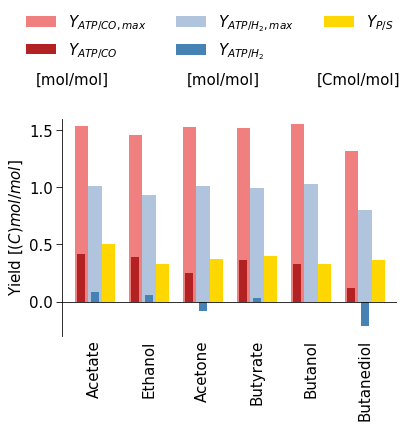

In [95]:
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False

X = ATP_carb.index
X_axis = np.arange(len(X))

plt.axis([-0.6, len(X)-0.4,-0.3, 1.6])
plt.bar(X_axis - 0.25, ATP_carb, 0.25, color = "lightcoral", label = '$Y_{ATP/CO,max}$')#' [mol/mol]')
plt.bar(X_axis - 0.25, Yields.ATPcarb, 0.15, color = "firebrick", label = '$Y_{ATP/CO}$')# [mol/mol]')
plt.bar(X_axis, 0, color = "w", label="")
plt.bar(X_axis + 0, ATP_hom, 0.25, color = "lightsteelblue", label = '$Y_{ATP/H_2,max}$')# [mol/mol]')
plt.bar(X_axis + 0, Yields.ATPhom, 0.15, color = "steelblue", label = '$Y_{ATP/H_2}$')# [mol/mol]')
plt.bar(X_axis + 0.25, Yields.YPShom, 0.25, color = "gold", label = '$Y_{P/S}$')# [Cmol/mol]')
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel(r'Yield [$(C)mol/mol$]', fontsize=15)

plt.tick_params(axis='x', which='major', labelsize=15, length = 0, labelrotation = 90)
plt.tick_params(axis='y', which='major', labelsize=15, length = 6)
plt.xticks(X_axis, X)
plt.text(-1.1, 1.9, "[mol/mol]", fontsize = 15)
plt.text(1.7, 1.9, "[mol/mol]", fontsize = 15)
plt.text(4.1, 1.9, "[Cmol/mol]", fontsize = 15)
plt.legend(loc='upper left', bbox_to_anchor=(-0.15, 1.55), ncol=3, fontsize=15, frameon=False)#, borderaxespad=0)
plt.show()

## Closer look, change x within [0:5] to view different product

In [7]:
x = 0

WLmodel.objective = objectives[x]

#Medium: choose one by commenting the other out
WLmodel.medium = medium_carb
#WLmodel.medium = medium_hom

solution = WLmodel.optimize()

Builder(model = WLmodel, map_json = '../Models/EscherMaps/WLPathway_Bifurcating.json')#, reaction_data = solution.fluxes.to_dict())

Builder()

In [8]:
Builder(model = WLmodel, map_json = '../Models/EscherMaps/AcetonePathway.json', reaction_data = solution.fluxes.to_dict())

Builder(reaction_data={'EX_h2_e': 0.0, 'EX_h2o_e': -0.3333333333333335, 'EX_co2_e': 2.0, 'EX_co_e': -4.0, 'EX_…